<a href="https://colab.research.google.com/github/seolibek/Tufts2024/blob/main/umap_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:

!pip install umap-learn

In [62]:
import numpy as np
import random
import matplotlib.pyplot as plt
import umap
from PIL import Image, ImageOps
import seaborn as sns
from scipy.optimize import nnls
from skimage.feature import peak_local_max
import ipywidgets as widgets
from ipywidgets import interactive
from datetime import datetime

In [ ]:
#for trial run, we start with penguin dataset...


In [63]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
penguins = pd.read_csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins.csv")
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


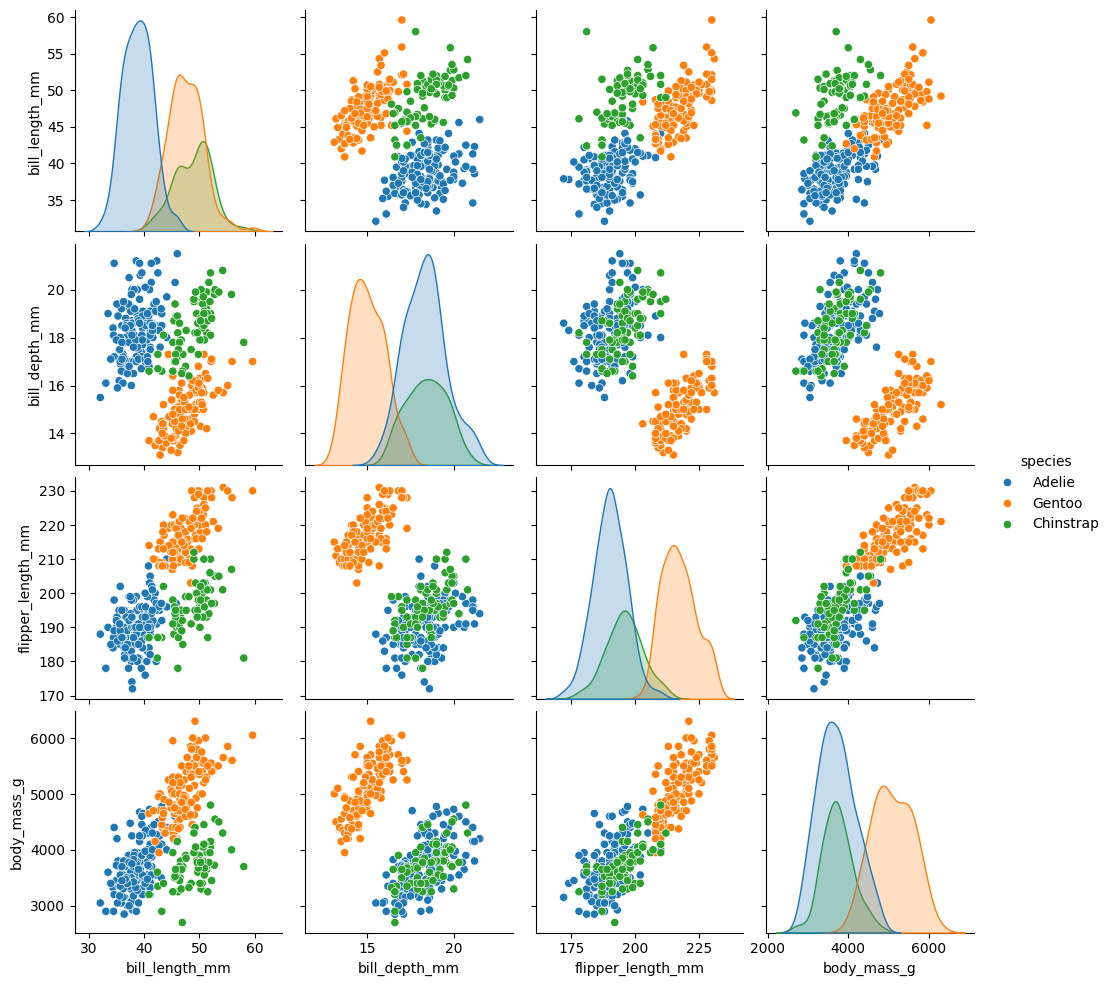

In [ ]:
penguins = penguins.dropna()
penguins.species.value_counts()
sns.pairplot(penguins.drop("year", axis=1), hue='species');


In [ ]:
reducer = umap.UMAP()


In [ ]:
penguin_data = penguins[
    [
        "bill_length_mm",
        "bill_depth_mm",
        "flipper_length_mm",
        "body_mass_g",
    ]
].values
scaled_penguin_data = StandardScaler().fit_transform(penguin_data)

In [ ]:
embedding = reducer.fit_transform(scaled_penguin_data)
embedding.shape

(333, 2)

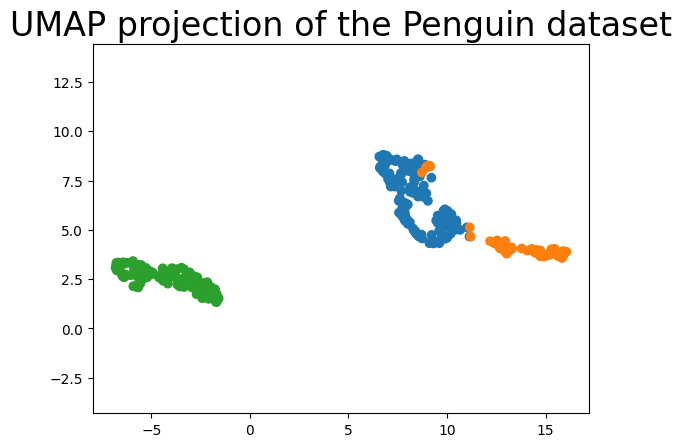

In [ ]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in penguins.species.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Penguin dataset', fontsize=24);

# UMAP on HSI data - SalinasA

Below is the first attempt at working with UMAP.

Notes:
UMAP accepts a two dimensional image. Thus, for example, when it works with MNIST, it just accepts MNIST.data. (See: documentation)

In our case, with HSI, there are three dimensions. We seek to extend the application of 2D images and UMAP to HSI imagery.



In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
cd MyDrive

[Errno 2] No such file or directory: 'MyDrive'
/content


Below, we load in our dataset.

This is a rewritten version of the MATLAB script from prewritten works (notably, Dr. Murphy's linked repositories)

(Updated from the github version in my repository, to fix small casting errors consistent with typical errors in translation from MATLAB to Python).

In [66]:
#read in the data
import numpy as np
import scipy.io

salinasA_path = '/content/drive/MyDrive/SalinasA_corrected.mat'
salinasA_gt_path = '/content/drive/MyDrive/SalinasA_gt.mat'

data = scipy.io.loadmat(salinasA_path)
HSI = data['salinasA_corrected']

data = scipy.io.loadmat(salinasA_gt_path)
GT = data['salinasA_gt']

M, N, D = HSI.shape
n = M * N
X = HSI.reshape((n, D))
X = X.astype(np.float64)
#normalzie columns

norms = np.sqrt(np.sum(X**2, axis = 0))
X /= norms

X += 1e-6 * np.random.randn(*X.shape)

HSI = X.reshape((M, N, D))

new_gt = np.zeros_like(GT)
unique_classes = np.unique(GT)
K = len(unique_classes)

for k, uc in enumerate(unique_classes, start=1):
    new_gt[GT == uc] = k
n = new_gt.size
Y = new_gt.reshape((n, 1))
GT = new_gt

Sanity check: Shape of all data objects

In [67]:
print(HSI.shape)
print(GT.shape)


(83, 86, 204)
(83, 86)


Below is code that is typical of running the UMAP dimensionality reduction. We note that the HSI data is reshaped to fit the dimensionality needs of UMAP, but consider that it may cause improper clustering.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
<ipython-input-68-0a723f37951b>:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], s=0.1, cmap='Spectral')


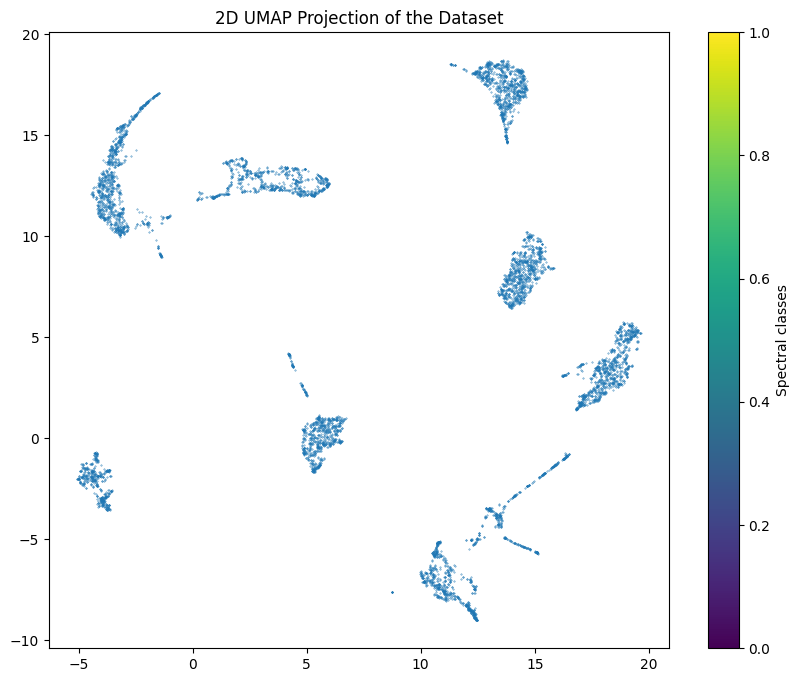

In [68]:
data_reshaped = HSI.reshape(-1, HSI.shape[2])

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(data_reshaped)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=0.1, cmap='Spectral')
plt.title('2D UMAP Projection of the Dataset')
plt.colorbar(label='Spectral classes')
plt.show()

Below is a graph based on ground truth? Still working throguh documenation to decipher what this line of code does, specifically.


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


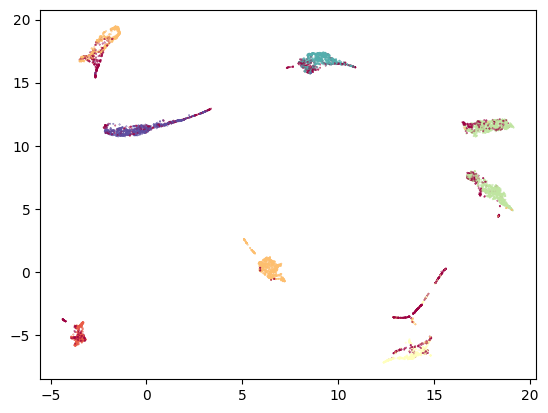

In [69]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(data_reshaped)

plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=GT, s=0.1, cmap='Spectral');

<ipython-input-70-b05be637447e>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  spectral_cmap = plt.cm.get_cmap('Spectral', n_classes)


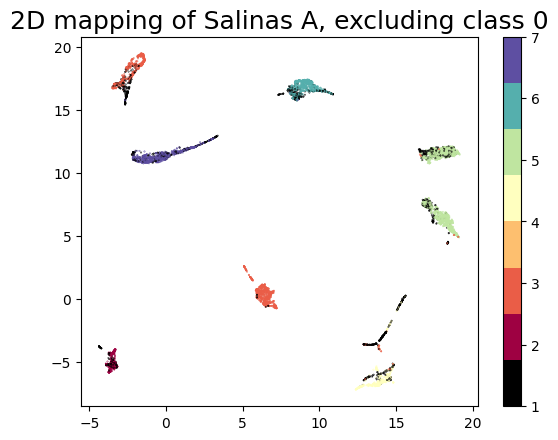

In [70]:
#Adjusting just salinas A for the label 0 difference:

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

n_classes = np.max(GT)
spectral_cmap = plt.cm.get_cmap('Spectral', n_classes)
colors = spectral_cmap(np.arange(n_classes))
colors = np.vstack(([[0, 0, 0, 1]], colors))
new_cmap = ListedColormap(colors)

# Plotting the UMAP embedding
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=GT, s=0.1, cmap=new_cmap)
plt.colorbar()  # Optional: to show the color bar
plt.title('2D mapping of Salinas A, excluding class 0', fontsize=18)
plt.show()


In [71]:
!pip install ffmpeg

In [101]:
#save for dimensionality purposes
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data_reshaped);
    fig = plt.figure()

    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=GT, s=4)
        plt.title(title, fontsize=18)
        def update(frame):
            ax.view_init(elev=10, azim=frame)
            return fig,

        # Creating the animation
        ani = FuncAnimation(fig, update, frames=range(0, 360, 2), blit=True)

        # To display the animation in Jupyter Notebook
        plt.show()

        # Optionally, save the animation
        ani.save('umap_rotation.mp4', writer='ffmpeg', fps=30)
    return u


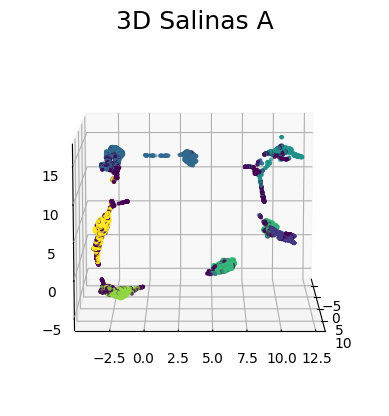

In [102]:
u = draw_umap(n_components=3,title='3D Salinas A')


Above are 2d plots and 3d plots, where UMAP is applied to the SalinasA dataset. Calling draw_umap automatically saves a video of a rotation of the 3d plot to the drive, clicking on it on the left hand tab allows for easy download and access.

Note: every time you run draw_umap, the video will be overwritten. If you want to save previous iterations in drive, make sure to rename in draw_umap.

Now, we seek to perform a k-means clustering, based on this umap dimensionality reduced dataset of Salinas A. Below, we run k-means and check the accuracy

In [148]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

def k_means_with_umap(data):

  GT_flat = GT.flatten()

  num_clusters = len(np.unique(GT_flat)) - (1 if 0 in GT_flat else 0)  # Adjust based on whether '0' should be excluded
  kmeans = KMeans(n_clusters=num_clusters, random_state=42)
  labels = kmeans.fit_predict(data)

  ari = adjusted_rand_score(GT_flat, labels)
  print("Adjusted Rand Index (ARI):", ari)
  return GT_flat, labels


In [149]:
gt_umap_3, labels_umap_3 = k_means_with_umap(u)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Rand Index (ARI): 0.5420775868414038


We check the results from clustering based on kmeans to a regular PCA, below:

In [124]:
from sklearn.decomposition import PCA

def kmeans_with_pca(data,n_components):
  GT_flat_PCA = GT.flatten()

  pca = PCA(n_components)
  data_reduced = pca.fit_transform(data)

  num_clusters = len(np.unique(GT_flat_PCA)) - (1 if 0 in GT_flat_PCA else 0)
  kmeans = KMeans(n_clusters=num_clusters, random_state=42)
  labels = kmeans.fit_predict(data_reduced)

  # Calculate Adjusted Rand Index (ARI)
  ari = adjusted_rand_score(GT_flat_PCA, labels)
  print("Adjusted Rand Index (ARI):", ari)
  return GT_flat_PCA, labels


In [126]:
gt_flat_pca_3, labels_pca_3 = kmeans_with_pca(data_reshaped,3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Rand Index (ARI): 0.3791122936600893


In [145]:
def reg_accuracy(true,pred):
  accuracy = np.mean(true == pred)
  return accuracy



In [151]:
print(reg_accuracy(gt_umap_3, labels_umap_3))
print(reg_accuracy(gt_flat_pca_3, labels_pca_3))


0.047212104230876996
0.07060801344914541


We note that the ARI using UMAP alone for dimensionality reduction, then running k-means gives an ARi of 0.54, whereas using PCA alone gives an ARI of 0.379.

However, when checking brute force accuracy, we note that the accuracy using UMAP is lower than that of PCA..

Below is a quick check to see the difference in using UMAP to map to a four dimensional case.

In [107]:
four_d_plot = draw_umap(n_components=4,title='3D Salinas A')


<Figure size 640x480 with 0 Axes>

In [152]:
gt_umap_4,lbl_umap_4 = k_means_with_umap(four_d_plot)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Rand Index (ARI): 0.5416964159954213


In [153]:
gt_pca_4, lbl_pca_4 = kmeans_with_pca(data_reshaped,4)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Rand Index (ARI): 0.3901635043827198


And similar to before, we calculate the brute force accuracy as well:

In [154]:
print(reg_accuracy(gt_umap_4, lbl_umap_4))
print(reg_accuracy(gt_pca_4, lbl_pca_4))


0.002241524236480807
0.07018772765480527
